In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

## About the code

We introduce a novel clustering approach for two-feature data using convolutions. By leveraging convolutions' ability to capture complex patterns, we identify dense regions, enhancing cluster assignment accuracy. Compared to DBSCAN, our algorithm demonstrates improved performance in capturing intricate spatial dependencies. This research contributes to advancing data analysis and pattern recognition techniques.

In [2]:
# --------- SHOW IMAGE -----------------------------------------------------------------------------------------------------
def show_img(x, ax=None, figsize=(5, 5), title=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes()

    if len(x.shape) == 3 and x.shape[2] == 3:
        # Immagine a colori (BGR)
        ax.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    else:
        # Immagine in scala di grigi
        ax.imshow(x, cmap='gray')

    if title:
        ax.set_title(title)


def create_gaussian_kernel(size, sigma):
    # Calcola il filtro gaussiano unidimensionale
    gaussian_1d = cv2.getGaussianKernel(size, sigma)
    
    # Calcola il prodotto esterno per ottenere il filtro gaussiano bidimensionale
    gaussian_kernel = np.outer(gaussian_1d, gaussian_1d)
    
    return gaussian_kernel

def generate_colors(num_clusters):
    colors = [tuple(np.random.randint(0, 255, 3)) for x in range(num_clusters)]
    return np.array(colors).tolist()


def filter_image(img, kernel_type='mean', sigma=50, size=3, ratio_scaler=0.75, loops=1, THR=125,
                 draw_type = 'line', thickness=2, radius=5,
                 show=True):
    start = time.time()
    original_img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # kernel (size x size)
    if kernel_type == 'mean':
        kernel = np.ones((size, size), np.float32) / int(size ** 2)
    elif kernel_type == 'gaussian':
        kernel = create_gaussian_kernel(size, sigma)
    else:
        raise ValueError('Wrong kernel_type chosen.')
    
    for i in range(loops):
        # Apply filter
        img = cv2.filter2D(img, -1, kernel)

        # Normalize at 255
        MAX = np.max(img)
        ratio = (255 * ratio_scaler) / MAX
        img = img * ratio
        img = np.round(img).astype(np.uint8)
        img = cv2.convertScaleAbs(img)

        # Apply THR
        img[img < THR] = 0
        
    filtered_img = img.copy()
    
    img_cluster = cv2.cvtColor(original_img, cv2.COLOR_BGR2BGRA)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if draw_type == 'line':
        centers = []
        for i, contour in enumerate(contours):
            # Compute center
            moments = cv2.moments(contour)
            if moments['m00'] != 0:
                center_x = int(moments['m10'] / moments['m00'])
                center_y = int(moments['m01'] / moments['m00'])
                centers.append([center_x, center_y])
                cv2.circle(img_cluster, (center_x, center_y), radius, (0, 0, 255), -1)
                # Draw contour
                cv2.drawContours(img_cluster, [contour], -1, (0, 255, 0), thickness)
                
    elif draw_type == 'area':
        colors = generate_colors(len(contours))
        for i, contour in enumerate(contours):
            fill_color = colors[i]
            # Creazione di un'immagine con canale alfa per il riempimento
            filled_area_with_alpha = np.zeros((img_cluster.shape[0], img_cluster.shape[1], 4), dtype=np.uint8)

            # Riempimento dell'area del contorno con il colore e l'opacità desiderati
            cv2.fillPoly(filled_area_with_alpha, [contour], fill_color)

            # Combinazione dell'immagine con trasparenza con l'immagine cluster utilizzando l'operatore OR
            img_cluster = cv2.bitwise_or(img_cluster, filled_area_with_alpha)
    else:
        raise ValueError('Choose a correct draw_type between \'line\' and \'area\'')
    end = time.time()
    clustering_time = end - start
    if show:
        fig, ax = plt.subplots(1, 3, figsize=(19,6))
        show_img(original_img, ax=ax[0], title='original image')
        show_img(filtered_img, ax=ax[1], title=f'type:{kernel_type}  (k_size:{size}, loops:{loops})')
        show_img(img_cluster, ax=ax[2], title=f'Convolutional Clustering')
        
    return img, filtered_img, img_cluster, clustering_time




In [3]:
from PIL import Image

def trova_coordinate_pallini(immagine):
    img = Image.open(immagine)
    larghezza, altezza = img.size
    coordinate_pallini = []
    
    for y in range(altezza):
        for x in range(larghezza):
            pixel = img.getpixel((x, y))
            if pixel == (255, 255, 255):  # Verifica se il pixel è bianco
                coordinate_pallini.append((x, y))
    
    return coordinate_pallini

import numpy as np
from sklearn.cluster import DBSCAN
import cv2
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


def find_optimal_eps(coordinates, min_samples):
    # Calcola la distanza media dei punti al punto più vicino
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(coordinates)
    distances, _ = nbrs.kneighbors(coordinates)
    avg_distances = np.max(distances, axis=1)

    # Calcola la derivata della curva delle distanze medie
    deltas = avg_distances[1:] - avg_distances[:-1]

    # Trova il punto di massima curvatura (gomito)
    kneedle = np.argmax(deltas) + 1

    # Restituisci il valore di eps corrispondente al punto di gomito
    return avg_distances[kneedle]

# def draw_clusters_on_image(coordinates, image_path, min_samples):
#     # Carica l'immagine utilizzando OpenCV
#     image = cv2.imread(image_path)

#     # Estrai le coordinate x e y dalla lista di coordinate
#     xy = np.array(coordinates)

#     # Trova il valore ottimale di eps utilizzando il metodo del knee
#     eps = find_optimal_eps(xy, min_samples)
#     print(eps)

#     # Crea un'istanza del modello DBSCAN
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)

#     # Esegui il clustering DBSCAN
#     clusters = dbscan.fit_predict(xy)

#     # Ottieni il numero di cluster trovati
#     num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

#     # Genera una lista di colori in base al numero di cluster
#     colors = generate_colors(num_clusters)

#     # Disegna i punti dei cluster sull'immagine con colori diversi
#     for i in range(num_clusters):
#         cluster_points = xy[clusters == i]
#         color = colors[i]
#         for point in cluster_points:
#             x, y = point
#             cv2.circle(image, (x, y), 5, color, -1)

#     show_img(image)
    
    
def draw_clusters_on_image(coordinates, image_path, eps, min_samples):
    # Carica l'immagine utilizzando OpenCV
    image = cv2.imread(image_path)

    # Estrai le coordinate x e y dalla lista di coordinate
    xy = np.array(coordinates)

    # Crea un'istanza del modello DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Esegui il clustering DBSCAN
    clusters = dbscan.fit_predict(xy)

    # Ottieni il numero di cluster trovati
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    # Genera una lista di colori in base al numero di cluster
    colors = generate_colors(num_clusters)

    # Disegna i punti dei cluster sull'immagine con colori diversi
    for i in range(num_clusters):
        cluster_points = xy[clusters == i]
        color = colors[i]
        for point in cluster_points:
            x, y = point
            cv2.circle(image, (x, y), 5, color, -1)

#     show_img(image)
    return image
    

Load image

------------------------file 1------------------------------
Average computational time: 0.029850006103515625


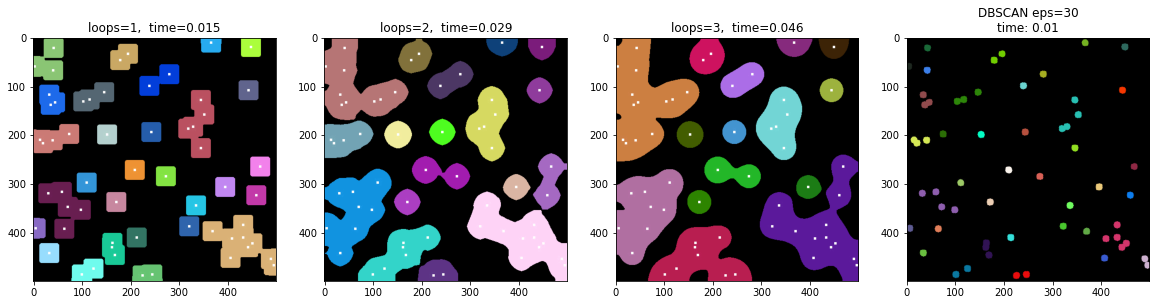

------------------------file 2------------------------------
Average computational time: 0.03408551216125488


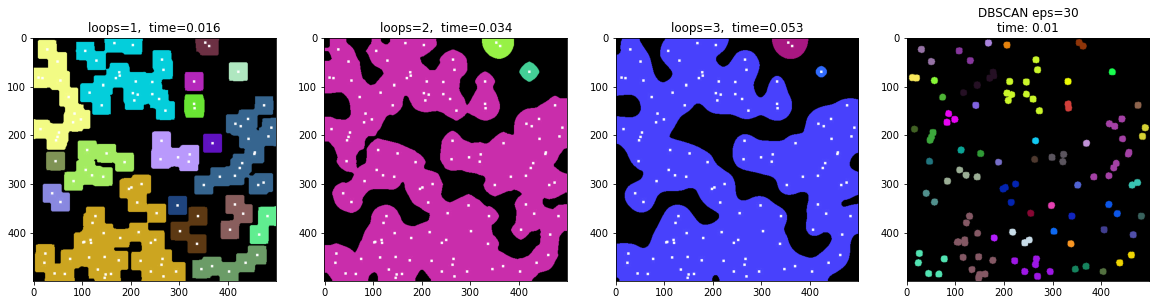

------------------------file 3------------------------------
Average computational time: 0.0361642042795817


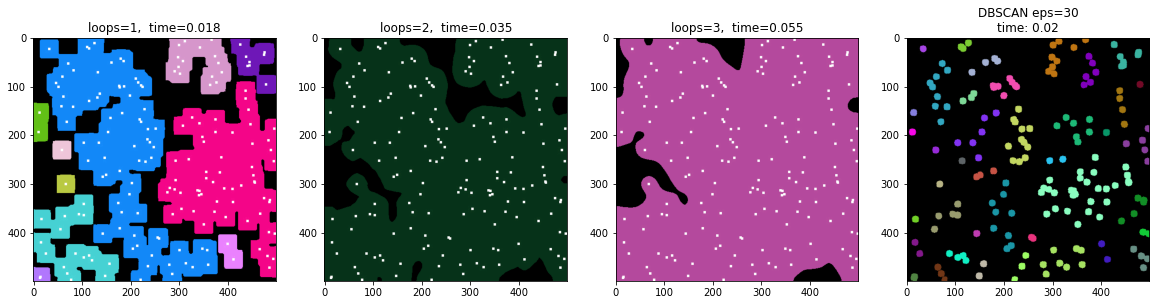

------------------------file 4------------------------------
Average computational time: 0.03182864189147949


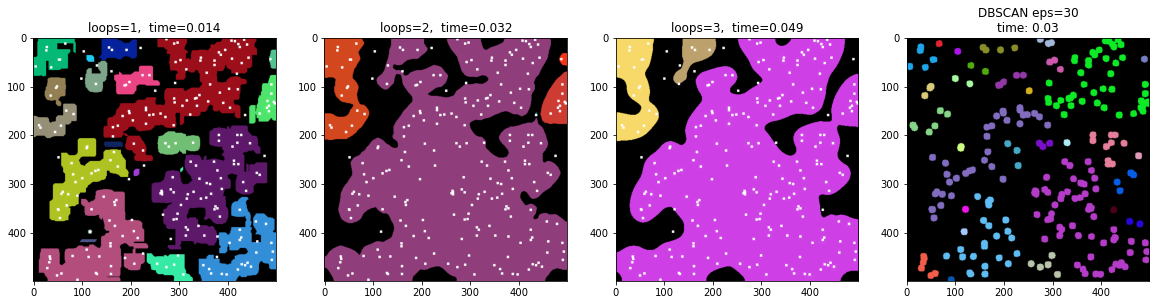

------------------------file 5------------------------------
Average computational time: 0.038408756256103516


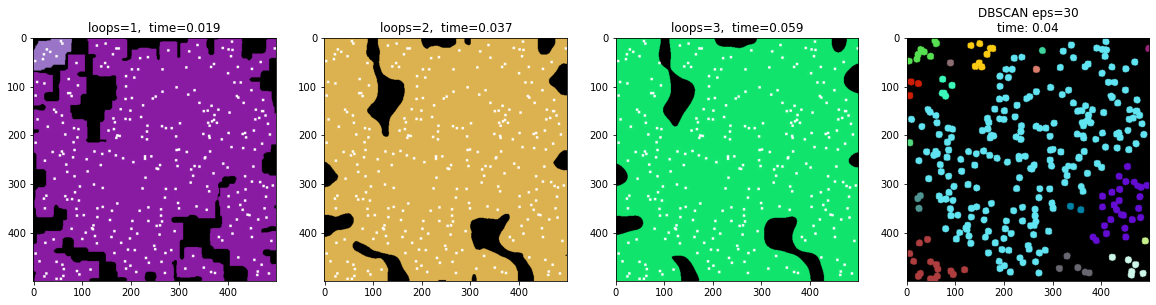

------------------------file 6------------------------------
Average computational time: 0.03785093625386556


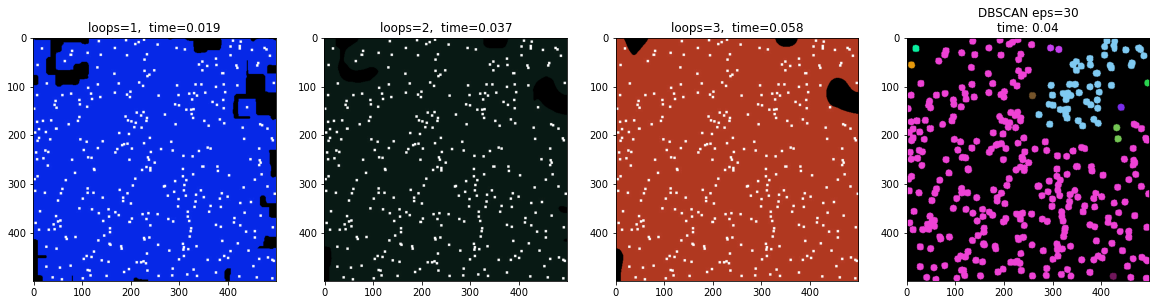

------------------------file 7------------------------------
Average computational time: 0.03902188936869303


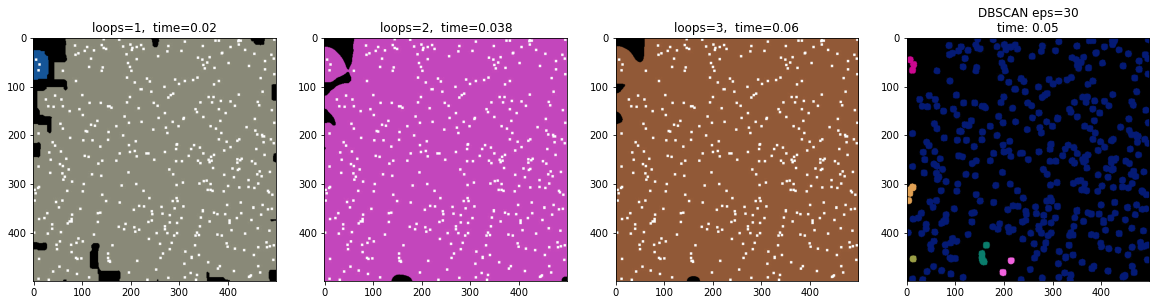

------------------------file 8------------------------------
Average computational time: 0.04183546702067057


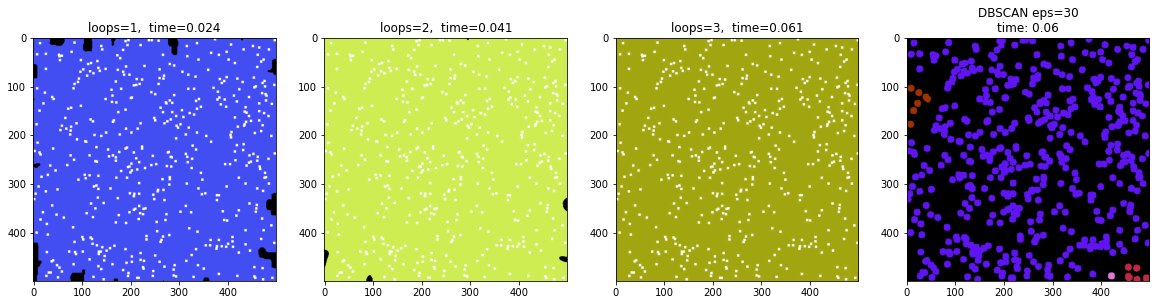

------------------------file 9------------------------------
Average computational time: 0.04249906539916992


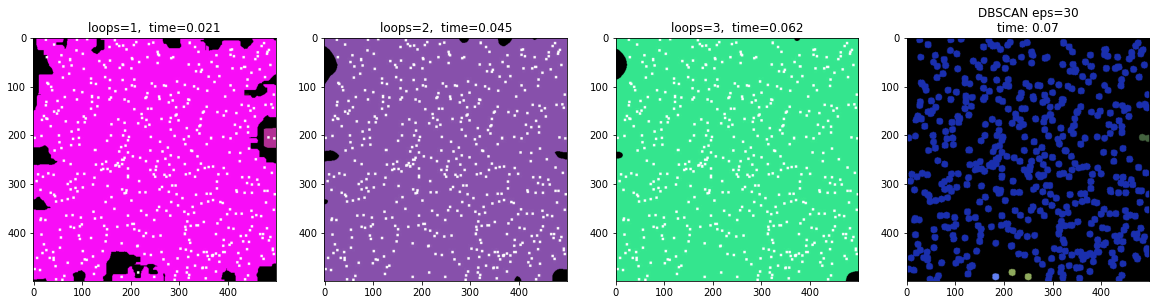

------------------------file 10------------------------------
Average computational time: 0.03885642687479655


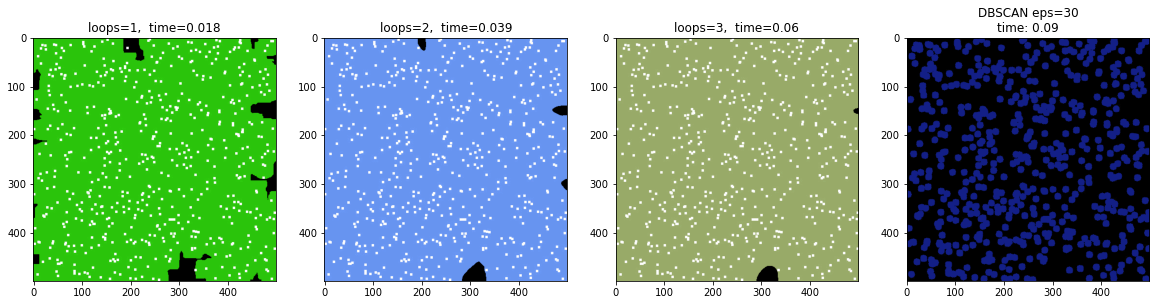

In [10]:

for i in range(1,11):
    print(f'------------------------file {i}------------------------------')
    times = []
    filename = f'dots/image_{i}.jpg'
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    size = int(np.sqrt(np.min(img.shape[:-1])) * 1.75) 
    
    kernel_type, loops, THR = 'gaussian', 5, int(255 * 0.1)
    # print(f'size: {size},  kernel type: {kernel_type},  loops: {loops},   THR (mean): {THR}')
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    for j, l in enumerate([1, 2, 3]):
        img2, filtered_img, img_cluster, t = filter_image(img, kernel_type=kernel_type, sigma=75, ratio_scaler=1,
                                                      size=size, loops=l, THR=THR,
                                                      thickness=1, radius=1, draw_type='area',
                                                      show=False)
        show_img(img_cluster, ax=ax[j], title=f'loops={l},  time={np.round(t, 3)}')
        times.append(t)
    print(f'Average computational time: {np.mean(times)}')
    
    #---------------------------
    lista = trova_coordinate_pallini(filename)
    s_db = time.time()
    eps = 30
    DBSCAN_img = draw_clusters_on_image(lista, filename, eps=eps, min_samples=5)
    e_db = time.time()
    show_img(DBSCAN_img, ax=ax[3], title=f'DBSCAN eps={eps}\ntime: {np.round(e_db - s_db, 2)}')
    #---------------------------
    plt.show()

-----------------------------------------------------------------------------

------------------------file 1------------------------------
Average computational time: 0.017904202143351238


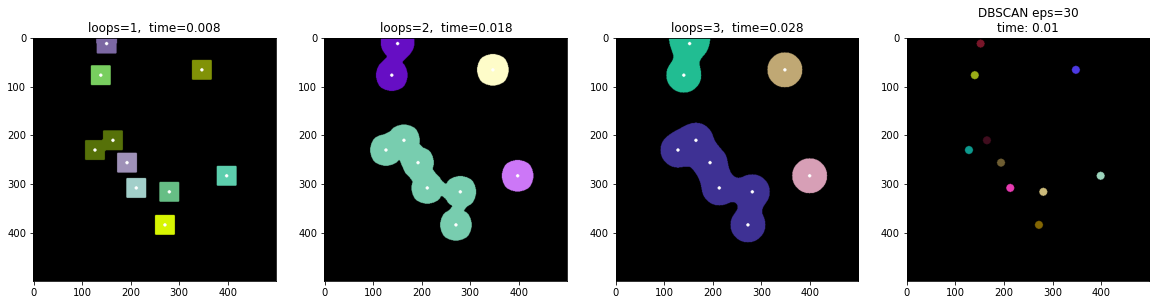

------------------------file 2------------------------------
Average computational time: 0.018805583318074543


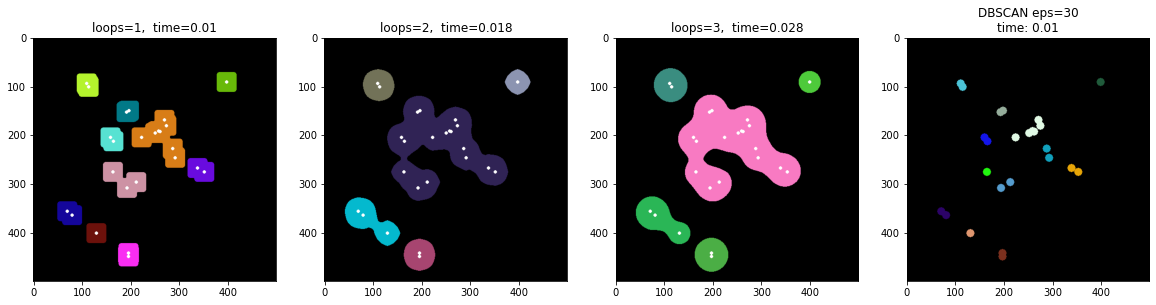

------------------------file 3------------------------------
Average computational time: 0.01866634686787923


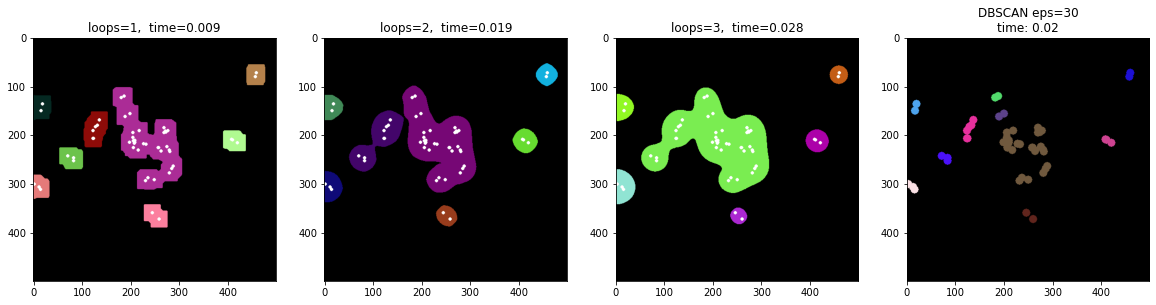

------------------------file 4------------------------------
Average computational time: 0.019532203674316406


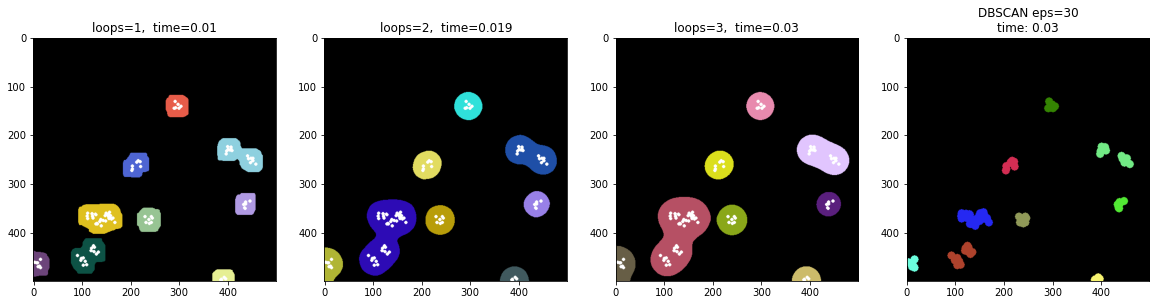

------------------------file 5------------------------------
Average computational time: 0.019856850306193035


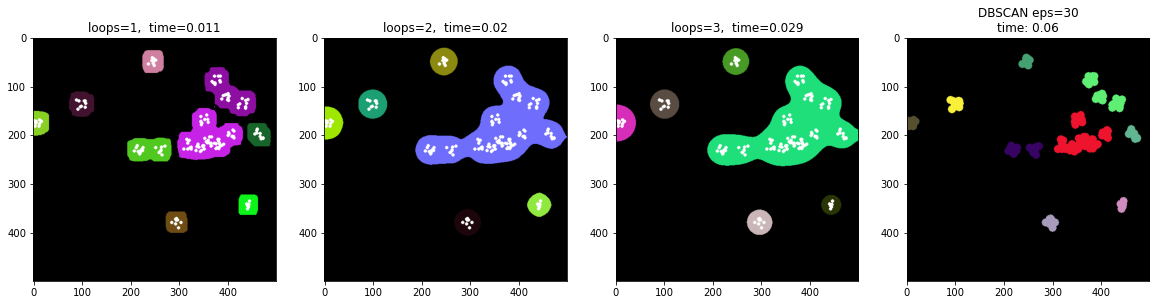

------------------------file 6------------------------------
Average computational time: 0.019996245702107746


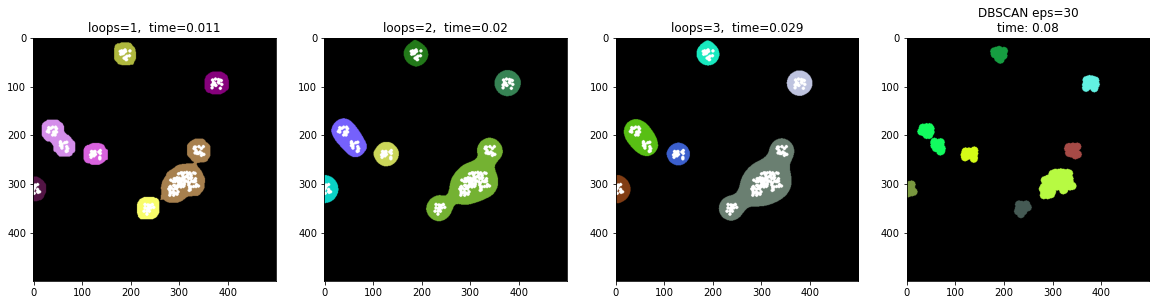

------------------------file 7------------------------------
Average computational time: 0.022959232330322266


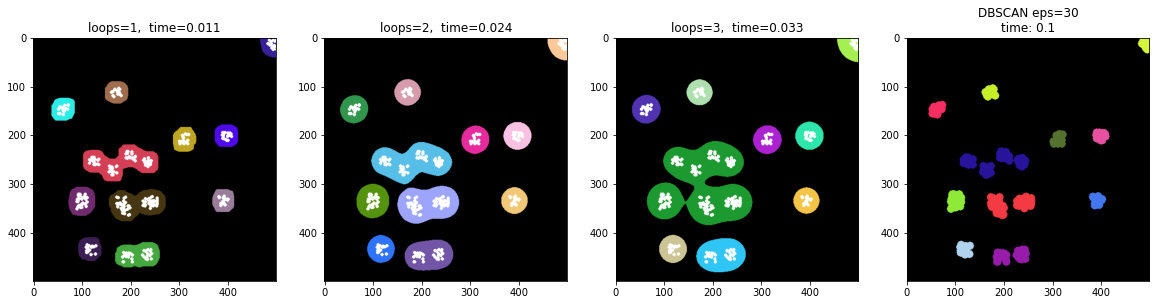

------------------------file 8------------------------------
Average computational time: 0.019843578338623047


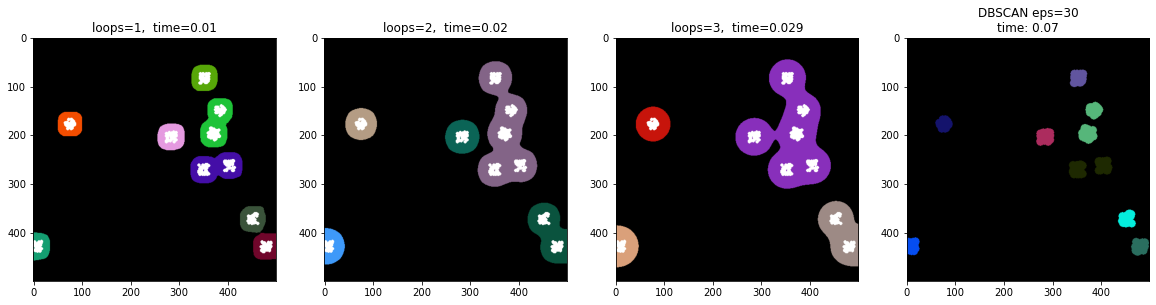

------------------------file 9------------------------------
Average computational time: 0.02052418390909831


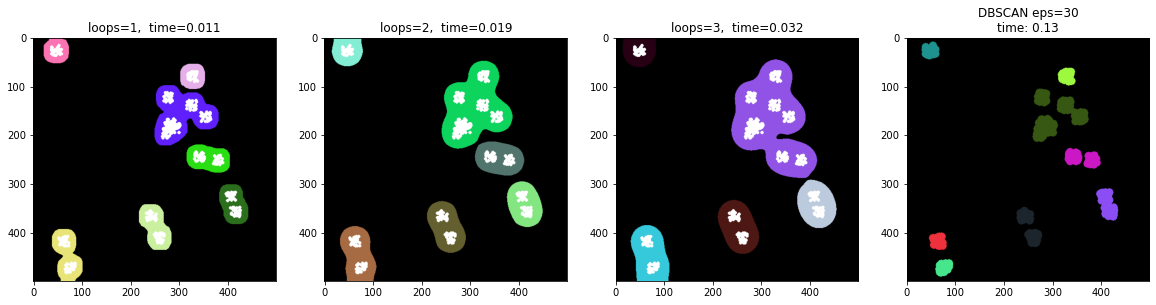

------------------------file 10------------------------------
Average computational time: 0.017742236455281574


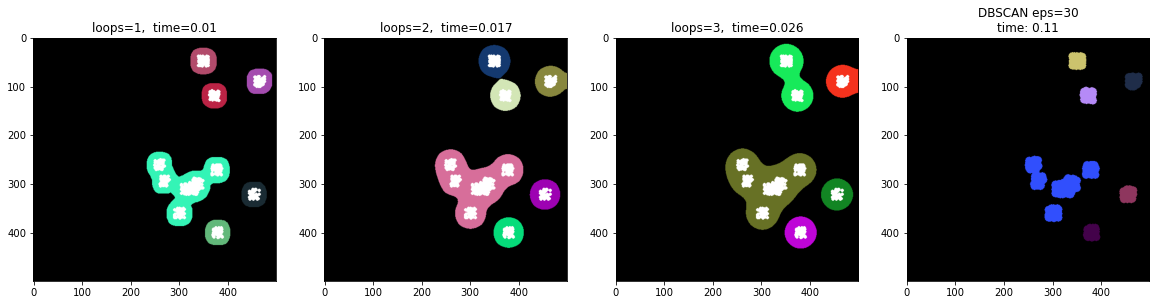

In [9]:
for i in range(1,11):
    print(f'------------------------file {i}------------------------------')
    times = []
    filename = f'patterns/image_{i}.png'
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    size = int(np.sqrt(np.min(img.shape[:-1])) * 1.75) 
    
    kernel_type, loops, THR = 'mean', 5, int(255 * 0.1)
    # print(f'size: {size},  kernel type: {kernel_type},  loops: {loops},   THR (mean): {THR}')
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    for j, l in enumerate([1, 2, 3]):
        img2, filtered_img, img_cluster, t = filter_image(img, kernel_type=kernel_type, sigma=75, ratio_scaler=0.9,
                                                      size=size, loops=l, THR=THR,
                                                      thickness=1, radius=1, draw_type='area',
                                                      show=False)
        show_img(img_cluster, ax=ax[j], title=f'loops={l},  time={np.round(t, 3)}')
        times.append(t)
    print(f'Average computational time: {np.mean(times)}')
    
    #---------------------------
    lista = trova_coordinate_pallini(filename)
    s_db = time.time()
    eps = 30
    DBSCAN_img = draw_clusters_on_image(lista, filename, eps=eps, min_samples=5)
    e_db = time.time()
    show_img(DBSCAN_img, ax=ax[3], title=f'DBSCAN eps={eps}\ntime: {np.round(e_db - s_db, 2)}')
    #---------------------------
    plt.show()

#### Observation:

Unlike DBSCAN, my Convolutional Clustering method is sensitive to point density: the clusters it finds enclose areas and points that share a higher density compared to others. This can be useful compared to DBSCAN when we want to search for points or regions that have stronger connections than the rest of the population, potentially leaving more outliers. In fact, in DBSCAN, if points are close to each other, they are 'automatically' classified together in a cluster, whereas in Convolutional Clustering, these points are classified together only if their belonging region is deemed 'dense' by the algorithm.

It is interesting to observe that for strong patterns and a large number of points, the Convolutional Clustering algorithm achieves similar performance to the DBSCAN Clustering algorithm with two loops, but it takes slightly more time.